In [1]:
import sys
import pandas as pd
sys.path.append('../src')
import data_io, params, SIF_embedding
import show_chunked

In [2]:
# input
wordfile = '/home/francisco/GitHub/SIF/data/glove.840B.300d.txt'   # word vector file, can be downloaded from GloVe website
weightfile = '/home/francisco/GitHub/SIF/auxiliary_data/enwiki_vocab_min200.txt' # each line is a word and its frequency
weightpara = 1e-3 # the parameter in the SIF weighting scheme, usually in the range [3e-5, 3e-3]
rmpc = 0
# rmpc = 1 # they usually set 1 ; number of principal components to remove in SIF weighting scheme

In [3]:
cnn_file = '/home/francisco/GitHub/cnn-dailymail/finished_files/chunked/train_000.bin'
abstract, sentences = show_chunked.getsentences(cnn_file)

features {
  feature {
    key: "abstract"
    value {
      bytes_list {
        value: "<s> mentally ill inmates in miami are housed on the `` forgotten floor \'\' </s> <s> judge steven leifman says most are there as a result of `` avoidable felonies \'\' </s> <s> while cnn tours facility , patient shouts : `` i am the son of the president \'\' </s> <s> leifman says the system is unjust and he \'s fighting for change . </s>"
      }
    }
  }
  feature {
    key: "article"
    value {
      bytes_list {
        value: "editor \'s note : in our behind the scenes series , cnn correspondents share their experiences in covering news and analyze the stories behind the events . here , soledad o\'brien takes users inside a jail where many of the inmates are mentally ill . an inmate housed on the `` forgotten floor , \'\' where many mentally ill inmates are housed in miami before trial . miami , florida -lrb- cnn -rrb- -- the ninth floor of the miami-dade pretrial detention facility is dubbe

In [4]:
# sentences = ['this is an example sentence', 'this is another sentence that is slightly longer']
print(abstract)

# load word vectors
(words, We) = data_io.getWordmap(wordfile)

['b"<s> mentally ill inmates in miami are housed on the `` forgotten floor \'\' </s> <s> judge steven leifman says most are there as a result of `` avoidable felonies \'\' </s> <s> while cnn tours facility , patient shouts : `` i am the son of the president \'\' </s> <s> leifman says the system is unjust and he \'s fighting for change .', '</s>"']


In [5]:
# load word weights
word2weight = data_io.getWordWeight(weightfile, weightpara) # word2weight['str'] is the weight for the word 'str'
weight4ind = data_io.getWeight(words, word2weight) # weight4ind[i] is the weight for the i-th word

sentences = ['test', 'other test']

In [33]:
abstract, sentences = show_chunked.getsentences(cnn_file)

features {
  feature {
    key: "abstract"
    value {
      bytes_list {
        value: "<s> mentally ill inmates in miami are housed on the `` forgotten floor \'\' </s> <s> judge steven leifman says most are there as a result of `` avoidable felonies \'\' </s> <s> while cnn tours facility , patient shouts : `` i am the son of the president \'\' </s> <s> leifman says the system is unjust and he \'s fighting for change . </s>"
      }
    }
  }
  feature {
    key: "article"
    value {
      bytes_list {
        value: "editor \'s note : in our behind the scenes series , cnn correspondents share their experiences in covering news and analyze the stories behind the events . here , soledad o\'brien takes users inside a jail where many of the inmates are mentally ill . an inmate housed on the `` forgotten floor , \'\' where many mentally ill inmates are housed in miami before trial . miami , florida -lrb- cnn -rrb- -- the ninth floor of the miami-dade pretrial detention facility is dubbe

In [6]:
# set parameters
params = params.params()
params.rmpc = rmpc

In [7]:
# load sentences
x, m = data_io.sentences2idx(sentences, words) # x is the array of word indices, m is the binary mask indicating whether there is a word in that location
w = data_io.seq2weight(x, m, weight4ind) # get word weights

# get SIF embedding
embeddings = SIF_embedding.SIF_embedding(We, x, w, params) # embedding[i,:] is the embedding for sentence i

In [8]:
# load sentences
abstract_x, abstract_m = data_io.sentences2idx(abstract, words) # x is the array of word indices, m is the binary mask indicating whether there is a word in that location
abstract_w = data_io.seq2weight(abstract_x, abstract_m, weight4ind) # get word weights

# get SIF embedding
abstract_embeddings = SIF_embedding.SIF_embedding(We, abstract_x, abstract_w, params) # embedding[i,:] is the embedding for sentence i

In [9]:
# Sentence embeddings
sdf = pd.DataFrame(sentences, columns=['sentence'])
emb = pd.DataFrame(embeddings, columns=['emb_%i' % x for x in range(embeddings.shape[1])])
sdf = pd.concat([sdf, emb], axis=1)

In [10]:
# Abstract embeddings
adf = pd.DataFrame(abstract, columns=['sentence'])
aemb = pd.DataFrame(abstract_embeddings, columns=['emb_%i' % x for x in range(abstract_embeddings.shape[1])])
adf = pd.concat([adf, aemb], axis=1)

In [11]:
adf.head()

,sentence,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_290,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299
0,"b""<s> mentally ill inmates in miami are housed...",0.022908,0.071156,0.020476,0.018421,0.054732,-0.046256,0.080958,-0.054592,-0.107311,...,0.061697,-0.080972,-0.07964,-0.023547,0.002054,0.045217,0.091082,0.013634,-0.084233,-0.056688
1,"</s>""",0.212150,-0.994560,1.178200,2.072100,-0.442710,0.587300,0.261280,-0.425540,0.030910,...,-0.199460,-0.198480,1.09150,-0.351070,-1.047200,-0.413820,-0.211390,0.934270,-0.932860,-0.514790


In [12]:
adf[adf.columns[1:]].dot(sdf[sdf.columns[1:]].T)

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
0,1.817512,2.292365,2.596830,2.382609,2.423058,2.762949,2.299929,2.581899,2.520371,2.509575,...,2.169849,3.204776,1.857283,2.199148,2.210345,1.971270,1.798427,2.101235,2.111192,1.908998
1,0.753979,-4.990673,-4.911323,8.817124,-6.669700,0.607116,-3.541776,-1.638142,-6.061621,20.103736,...,-6.527407,-6.680961,-1.245231,-6.110955,-5.538870,4.242819,7.143908,-5.086400,12.846627,26.417403


algorithm example: single article
(k = # of sentences; e = embedding dimension)

take (k, e) = x (sentence embeddings)
create bit representation of sentence summary decisions (1, k) = b
use x into f(x, b) => h(x, b) then produce two outputs to choose summary with optimal reward
backprop



two approaches: streaming vs non

streaming based:
 
look at current sentence, create embedding, have current bit representation of past actions (initialized empty)
maybe some embedding for predicted summary? then evaluate everything else

article based:

score all of the sentences, Chris said to iterate over article a couple of times...not sure how this makes sense without backprop

In [13]:
adf.head()

,sentence,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_290,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299
0,"b""<s> mentally ill inmates in miami are housed...",0.022908,0.071156,0.020476,0.018421,0.054732,-0.046256,0.080958,-0.054592,-0.107311,...,0.061697,-0.080972,-0.07964,-0.023547,0.002054,0.045217,0.091082,0.013634,-0.084233,-0.056688
1,"</s>""",0.212150,-0.994560,1.178200,2.072100,-0.442710,0.587300,0.261280,-0.425540,0.030910,...,-0.199460,-0.198480,1.09150,-0.351070,-1.047200,-0.413820,-0.211390,0.934270,-0.932860,-0.514790


In [14]:
sdf.head()

,sentence,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,emb_8,...,emb_290,emb_291,emb_292,emb_293,emb_294,emb_295,emb_296,emb_297,emb_298,emb_299
0,"b""editor 's note : in our behind the scenes se...",-0.032912,0.042397,0.031326,0.148815,-0.005044,0.061765,-0.042820,0.020897,-0.008707,...,-0.155933,0.062875,-0.047902,-0.027060,-0.075693,-0.161862,-0.013952,-0.057433,-0.006306,-0.022029
1,"here , soledad o'brien takes users inside a ja...",0.019653,0.105582,-0.032739,-0.062289,-0.007770,-0.096966,-0.034363,-0.116381,0.015522,...,-0.045381,-0.101878,-0.103699,-0.002594,-0.056704,-0.028815,0.003903,-0.038061,-0.199252,0.018881
2,"an inmate housed on the `` forgotten floor , '...",0.096693,0.013868,-0.015701,-0.101575,0.068017,-0.036213,-0.031631,-0.147130,-0.026003,...,-0.001189,-0.150899,-0.018053,0.050539,-0.083624,0.007458,0.082060,0.014343,-0.087338,-0.000591
3,"miami , florida -lrb- cnn -rrb- -- the ninth f...",0.027993,0.086192,0.170021,0.144501,0.157027,0.029404,0.058522,-0.075552,-0.037065,...,0.101818,-0.118518,0.059976,0.031895,-0.104899,-0.052007,0.025132,0.088880,-0.156214,-0.061895
4,"here , inmates with the most severe mental ill...",-0.007857,0.107740,-0.081650,-0.081380,0.005123,-0.116588,0.007774,-0.009557,0.075650,...,-0.089699,-0.036341,-0.126280,-0.045463,-0.129258,0.005660,0.032350,-0.075145,-0.063582,-0.024497


In [18]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [19]:
import pickle
import numpy as np
from collections import Counter

In [20]:
from matplotlib import pyplot as plt
%matplotlib inline

In [21]:
sdf['sentence'][0]

'b"editor \'s note : in our behind the scenes series , cnn correspondents share their experiences in covering news and analyze the stories behind the events .'

In [40]:
# ax = adf.loc[0, adf.columns[1:]].values
sx = sdf.loc[0, sdf.columns[1:]].values

In [58]:
class BoWRegressor(nn.Module):  # inheriting from nn.Module!
    # calls the init function of nn.Module.  Dont get confused by syntax, always do it in an nn.Module
    def __init__(self, input_size, outputsize):        
        super(BoWRegressor, self).__init__()        
        self.linear = nn.Linear(input_size, outputsize)
        
    def forward(self, bow_vec):
        return F.sigmoid(self.linear(bow_vec))
    
def rougeScores(genSummary, refSummary):
    genTotal, refTotal, intersection = 0, 0, 0
    for token in list(set(list(refSummary.keys()) + list(genSummary.keys()) )):
        intersection += min(refSummary[token], genSummary[token])
        refTotal += refSummary[token]
        genTotal += genSummary[token]

    recall = intersection / float(refTotal) if float(refTotal) > 0 else 0
    prec   = intersection / float(genTotal) if float(genTotal) > 0 else 0
    f1 = (2 * recall * prec) / (recall + prec) if (recall + prec) > 0 else 0
    
    return recall, prec, f1

In [72]:
recall, prec, f1 = rougeScores(Counter(adf['sentence'][0].split(" ")), Counter(sdf['sentence'][0].split(" ")))

In [83]:
train_xs = torch.FloatTensor(sx.reshape(1, sx.shape[0]))
train_ys = torch.from_numpy(np.asarray([0, f1]).reshape(1,2)).float()

In [87]:
model = BoWRegressor(300, 2)

model.zero_grad()
loss_function = nn.MSELoss()

In [88]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

lossf = {'loss': [], 'epoch': []}
for epoch in range(100):
    model.zero_grad()
    
    rouge_preds = model(autograd.Variable(train_xs))
    loss = loss_function(rouge_preds, autograd.Variable(train_ys))
    loss.backward()
    optimizer.step()
    lossf['loss'].append(loss.data[0])
    lossf['epoch'].append(epoch)

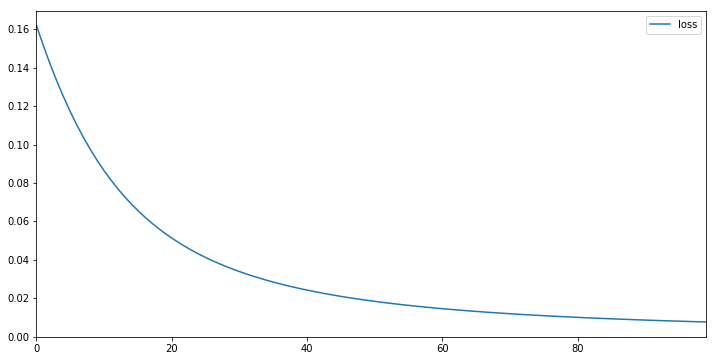

In [89]:
perf = pd.DataFrame(lossf)

perf.plot(y='loss', figsize=(12, 6))
plt.show()